In [ ]:
#Import packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
from time import sleep, perf_counter
from threading import Thread, Barrier, Lock
import threading
from random import randrange, randint
from IPython.display import clear_output
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [ ]:
#System Parameters
n_nodes = 200                         #Number of nodes in the network
radius = 5                        #Area around the node that will cause a connection
seed = 2                              #Seed used to generate the nodes
topology = "full mesh"        

initial_node_type = "center"          #First infected node type. Options: 1.manual select 2. edge density 3. center
first_infected_node = 0               #First infected node in the system

antientropy_type = "pull"             #Type of anti entropy algorithm used. Options: 1. push 2. pull 3. push-pull
message_failure_prob = 0              #Probability of a message not reaching its destination
node_failure_prob = 0                 #Probability of a node crash (por mil)

In [ ]:
#Auxiliary functions

#global variable
color_map = []                        #Data structer that stores the state of all nodes
updated_color_map = []                #Same as color_map
threads = []                          #List of threads
lc = Lock()                           #Barrier used to force threads to wait until all of them run an iteration
messages = []                         #List of the number of messages sent per round
avg_messages = []
n_mess = 0
progress = []                         #List of the number of infected nodes per round
avg_progress = []                     #List of average infected nodes when simulating several times
occ = []                              #Helper list, used to calculate the average (avg_progress)
crash_list = []
G = None
pos = None
connections_array = []

#This function serves the purpose of changing the color of an input node, meaning it is infected
def infect_node(map, node):
  map[node] = 'red'
  return

#Draw the graph
def draw_graph(title=""):
  global G, pos
  plt.figure(figsize=(8, 8))
  nx.draw_networkx_edges(G, pos, alpha=0.4)
  nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map)
  plt.axis("off")
  plt.title(title)
  plt.show()
  return

#Used to update the image with the graph
def update_graph(title):
  sleep(0.5)
  clear_output(wait=True)
  draw_graph(title)
  return

#Counts the number of infected nodes and returns it
def count_infected():
  c=0
  for i in range(len(color_map)):
    if color_map[i] == "red":
      c+=1
  return c

def init_infection():
  generate_network()

  progress.clear()
  messages.clear()
  color_map.clear()
  updated_color_map.clear()
  threads.clear()
  crash_list.clear()
  progress.append(count_infected())
  messages.append(n_mess)

  for i in range(n_nodes):
    color_map.append('green')
    updated_color_map.append('green')

  ncenter = 0
  if initial_node_type == "manual select":
    ncenter = first_infected_node
  if initial_node_type == "edge density":
    n_max = 0
    for i in range(n_nodes):
      if G.degree(i) > n_max:
        n_max = G.degree(i)
        ncenter = i
  if initial_node_type == "center":
    dmin = 1000
    posx_avg = 0
    posy_avg = 0
    for i in range(n_nodes):
      posx_avg += np.sum(pos[i][0])
      posy_avg += np.sum(pos[i][1])
    posx_avg = posx_avg/n_nodes
    posy_avg = posy_avg/n_nodes
    for n in pos:
      x, y = pos[n]
      d = np.sqrt((x - posx_avg) ** 2 + (y - posy_avg) ** 2)
      if d < dmin:
        ncenter = n
        dmin = d

  infect_node(color_map, ncenter)
  infect_node(updated_color_map, ncenter)
  return

#--------------------------------------------------------
def generate_network():
  #Generate network nodes and connections
  global G
  global pos
  global connections_array

  if topology == "mesh":
    G = nx.random_geometric_graph(n_nodes, 0.125,seed=2)
    pos = nx.get_node_attributes(G, "pos")
  if topology == "full mesh":
    G = nx.random_geometric_graph(n_nodes, 5,seed=2)
    pos = nx.get_node_attributes(G, "pos")
  if topology == "tree":
    G = nx.random_tree(n_nodes, seed=seed)
    pos = graphviz_layout(G, prog="twopi")
  if topology == "line":
    G = nx.path_graph(n_nodes)
    pos = nx.spring_layout(G, seed=1)
  if topology == "star":
    G = nx.star_graph(n_nodes-1)
    pos = nx.spring_layout(G, seed=1)


  #Create an array with all the node i connections
  for i in range(n_nodes):
    connections_array.append(list(G.neighbors(i)))


#init_infection()
#draw_graph()

In [ ]:
#threads

def check_crash(index):
  for i in range(len(crash_list)):
    if crash_list[i] == index:
      return 1
  if randrange(100) < node_failure_prob:
    crash_list.append(index)
    G.remove_node(index)
    return 1
  return 0

#This is the function that all threads will run
def ae_push(neighbor, index):
  global n_mess
  lc.acquire()
  if check_crash(index):
    lc.release()
    return
  if color_map[index] == "red":                           #if thread(node) has the message to transmit/is infected
    new = randrange(len(neighbor))                        #Choose random node from the list of neighbors
    n_mess += 1                                           #"Send" message
    if randrange(100) > message_failure_prob:             #Calculate if message is delivered
      infect_node(updated_color_map, neighbor[new])       #If it is, infect the node
  lc.release()
  return

def ae_pull(neighbor, index):
  global n_mess
  lc.acquire()
  if check_crash(index):
    lc.release()
    return
  if color_map[index] == "green":                         #if it doesnt have the message
    new = randrange(len(neighbor))                        #select a random node from the list of neighbors
    n_mess += 1                                           #Send message
    if randrange(100) > message_failure_prob:             #Calculate if message is delivered
      if color_map[neighbor[new]] == "red":               #if the selected node has the message
        n_mess += 1                                       #Send message back
        if randrange(100) > message_failure_prob:         #Calculate if message is delivered
          infect_node(updated_color_map, index)           #Infect the node
  lc.release()
  return

def ae_push_pull(neighbor, index):
  global n_mess
  lc.acquire()
  if check_crash(index):
    lc.release()
    return
  new = randrange(len(neighbor))                          #Choose random node from the list of neighbors
  if color_map[index] == "red":                           #if this node has the message
    n_mess += 1                                           #Send message
    if randrange(100) > message_failure_prob:             #Calculate delivery problem
      if color_map[neighbor[new]] == "green":             #If it doesnt have the message
        infect_node(updated_color_map, neighbor[new])     #Update
      n_mess += 1                                         #Send back message
  elif color_map[index] == "green":                       #if this node doesnt have the message
    n_mess += 1                                           #Send message
    if randrange(100) > message_failure_prob:             #Calculate if message is delivered
      if color_map[neighbor[new]] == "red":               #if the selected node has the message, update
        if randrange(100) > message_failure_prob:         #Calculate delivery problem
          infect_node(updated_color_map, index)           #Update
      n_mess += 1                                         #Send back message
  lc.release()
  return


def start_sim(type=antientropy_type, show_infection = False):
  avg_progress.clear()
  avg_messages.clear()
  occ.clear()
  for i in range(30):
    global threads
    global n_mess
    init_infection()
    if show_infection == True:
      update_graph("")
    while count_infected() < n_nodes - len(crash_list):
      if type == "push":
        for i in range(n_nodes):
          threads.append(Thread(target=ae_push, args=(connections_array[i],i)))
          threads[i].start()
      elif type == "pull":
        for i in range(n_nodes):
          threads.append(Thread(target=ae_pull, args=(connections_array[i],i)))
          threads[i].start()
      elif type == "push-pull":
        for i in range(n_nodes):
          threads.append(Thread(target=ae_push_pull, args=(connections_array[i],i)))
          threads[i].start()
          
      for t in threads:
        t.join()

      for t in range(0, len(color_map)):
        color_map[t] = updated_color_map[t]
      progress.append(count_infected())
      messages.append(n_mess)
      n_mess = 0
      threads = []
      
      if show_infection == True:
        update_graph("")

    for k in range(len(progress)):
      if k+1 > len(avg_progress):
        avg_progress.append(progress[k])
        avg_messages.append(messages[k])
        occ.append(1)
      else:
        avg_progress[k] += progress[k]
        avg_messages[k] += messages[k]
        occ[k] += 1

  for i in range(len(avg_progress)):
    avg_progress[i] = avg_progress[i]/occ[i]
    avg_messages[i] = avg_messages[i]/occ[i]

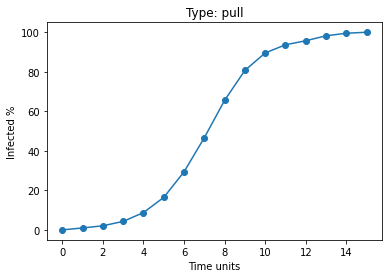

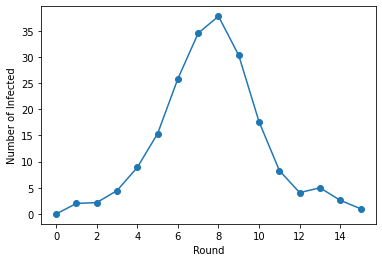

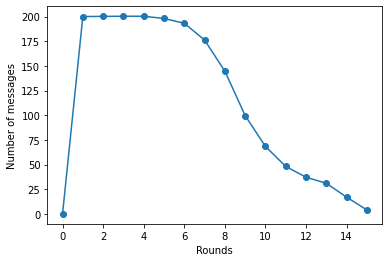

In [ ]:
def graph_perc():
  perc_progress = []
  x = range(0,len(avg_progress))
  for i in range(len(avg_progress)):
    perc_progress.append(avg_progress[i]*100/n_nodes)
  plt.plot(x, perc_progress, '-o')
  plt.ylabel("Infected %")
  plt.xlabel("Time units")
  plt.title("Type: " + antientropy_type)
  plt.show()

def graph_inf():
  new_progress = []
  x = range(0,len(avg_progress))
  for i in range(len(avg_progress)):
    if i == 0:
      new_progress.append(avg_progress[i])
    else:
      new_progress.append(avg_progress[i]-avg_progress[i-1])
  plt.plot(x, new_progress, '-o')
  plt.ylabel("Number of Infected")
  plt.xlabel("Round")
  plt.show()

def graph_messages():
  x = range(0,len(avg_messages))
  plt.plot(x, avg_messages, '-o')
  plt.ylabel("Number of messages")
  plt.xlabel("Rounds")
  plt.show()

#--------------------------------------------------------------------

start_sim()
#start_sim(show_infection=True)

graph_perc()
graph_inf()
graph_messages()


In [ ]:
#This cell will be used to print information about the simulation above

for i in range(len(avg_progress)):
  if avg_progress[i] >= 0.25*n_nodes:
    print("Number of rounds to infect 25%: ", i)
    break

for i in range(len(avg_progress)):
  if avg_progress[i] >= 0.5*n_nodes:
    print("Number of rounds to infect 50%: ", i)
    break

for i in range(len(avg_progress)):
  if avg_progress[i] >= 0.75*n_nodes:
    print("Number of rounds to infect 75%: ", i)
    break

print("Number of rounds to infect 100%: ", len(avg_progress))

print("\n")

print("Total number of messages: ", round(sum(avg_messages)))
print("Number of messages per round: ", round(sum(avg_messages)/len(avg_messages),2))
print("Number of messages per node: ", round(sum(avg_messages)/n_nodes, 2))
print("Number of messages per node per round:", round(sum(avg_messages)/n_nodes/len(avg_messages), 3))

Number of rounds to infect 25%:  35
Number of rounds to infect 50%:  92
Number of rounds to infect 75%:  158
Number of rounds to infect 100%:  246


Total number of messages:  97519
Number of messages per round:  396.42
Number of messages per node:  487.59
Number of messages per node per round: 1.982


In [ ]:
#Test all three together
perc_progress = []
avg_progress.clear()
occ.clear()
start_sim("push")
x = range(0,len(avg_progress))
for i in range(len(avg_progress)):
  perc_progress.append(avg_progress[i]*100/n_nodes)
plt.plot(x, perc_progress, '-o', color="g", label="push")
plt.xticks(x)

perc_progress.clear()
avg_progress.clear()
occ.clear()
start_sim("pull")
x = range(0,len(avg_progress))
for i in range(len(avg_progress)):
  perc_progress.append(avg_progress[i]*100/n_nodes)
plt.plot(x, perc_progress, '-o', color="orange", label="pull")

perc_progress.clear()
avg_progress.clear()
occ.clear()
start_sim("push-pull")
x = range(0,len(avg_progress))
for i in range(len(avg_progress)):
  perc_progress.append(avg_progress[i]*100/n_nodes)
plt.plot(x, perc_progress, '-o', color="blue", label="push-pull")

plt.ylabel("Infected %")
plt.xlabel("Time units")
plt.title("Comparison of the 3 types")
plt.legend()
from google.colab import files
plt.savefig("compare_all_fullmesh.png")
files.download("compare_all_fullmesh.png")
plt.show()



KeyboardInterrupt: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

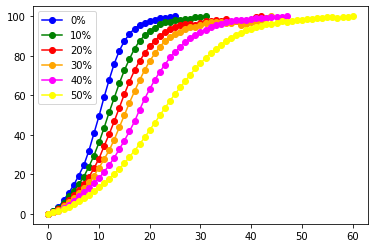

In [ ]:
avg_progress.clear()
occ.clear()

colors = ["blue", "green", "red", "orange", "magenta", "yellow"]
labels = ["0%", "10%", "20%", "30%", "40%", "50%"]

for j in range(len(labels)):
  perc_progress = []
  avg_progress.clear()
  occ.clear()
  message_failure_prob = j*10
  start_sim()
  x = range(0,len(avg_progress))
  for i in range(len(avg_progress)):
    perc_progress.append(avg_progress[i]*100/n_nodes)
  plt.plot(x, perc_progress, '-o', color=colors[j], label=labels[j])

plt.legend()
from google.colab import files
plt.savefig("compare_msg_failure_push-pull_mesh.png")
files.download("compare_msg_failure_push-pull_mesh.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

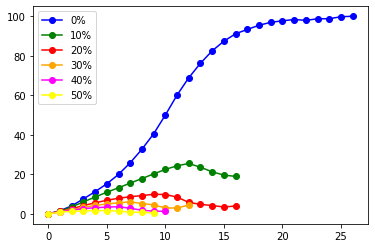

In [ ]:
avg_progress.clear()
occ.clear()

colors = ["blue", "green", "red", "orange", "magenta", "yellow"]
labels = ["0%", "10%", "20%", "30%", "40%", "50%"]

for j in range(len(labels)):
  perc_progress = []
  avg_progress.clear()
  occ.clear()
  node_failure_prob = j*10
  start_sim()
  x = range(0,len(avg_progress))
  for i in range(len(avg_progress)):
    perc_progress.append(avg_progress[i]*100/n_nodes)
  plt.plot(x, perc_progress, '-o', color=colors[j], label=labels[j])

plt.legend()
from google.colab import files
plt.savefig("compare_node_failure_push-pull_mesh.png")
files.download("compare_node_failure_push-pull_mesh.png")
plt.show()